## Portfolio Assignment week 03

This week's focus is on anomaly detection. As part of the portfolio assignment, you are required to make a contribution using anomaly detection algorithm(s). There are several options for your contribution, so you can choose the one that aligns with your learning style or interests the most

## Anomaly Detection

Anomaly detection in machine learning refers to the process of identifying patterns or instances in a dataset that deviate significantly from the norm or expected behavior. Anomalies, also known as outliers, are data points that are rare, unusual, or don't conform to the typical patterns observed in the majority of the data. Anomaly detection algorithms aim to automatically detect these anomalies. Anomaly detection in machine learning has various applications across domains, including predictive maintenance, and healthcare monitoring. By automatically identifying anomalies, these algorithms help in detecting potential risks. 


## Anomaly Detection Assignment

Study the notebook `Study_Case_Anomoly_Detection` 

Choose at least 1 out of the listed assignments below

- Analyze the end result plot to evaluate the algorithm's performance. Look for anomalies identified by the algorithm and compare them to known anomalies or instances of abnormal behavior in the data. Assess whether the algorithm successfully captures these anomalies and if it shows promising results in detecting abnormal patterns. Based on the plot analysis, provide argumentation for the validity of the anomaly detection algorithm hypothesis (see above). Discuss how the algorithm effectively captures anomalies in the time series data and why it is a suitable approach for the use case. Support your argument with references to relevant literature that discuss the effectiveness of the chosen algorithm or similar algorithms in detecting anomalies in time series data.
- To improve data quality for anomaly detection in time series data, we can focus on removing outliers due to sensor reading errors while preserving anomalies. Additionally, performing resampling or aggregation can help reduce noise and highlight higher-level patterns relevant for anomaly detection. Find common steps to improve data quality for this particular use and implement those. Evaluate the performance of the algorithms compare to the original notebook.
- Try another algorithm that has not been tested in the notebook. Provide argumentation for the validity of the anomaly detection algorithm you choose.
- Try to find the best configuration for one of the tested algorithms
- Try anomaly detection on a different dataset without timeseries data. Intrepret the results

Do not forget to reference sources!

---

In [1]:
#Import modules
import pandas as pd
import matplotlib.pyplot as plt
import yaml

In [2]:
# load the data
with open('config.yaml', 'r') as conf:
    config = yaml.load(conf, yaml.SafeLoader)

sensor_data = pd.read_csv(config['sensor_data']) #from https://www.kaggle.com/datasets/nphantawee/pump-sensor-data

In [3]:
sensor_data = sensor_data.drop(columns='Unnamed: 0')

sensor_data.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [4]:
#missing values from the example notebook. Good code
percentage_missing = sensor_data.isnull().sum().sort_values(ascending=False)/len(sensor_data)*100
percentage_missing.head() # show 5 largest missing %

# dropping low quality sensors
sensor_data.drop(columns=['sensor_15','sensor_50'], inplace= True)


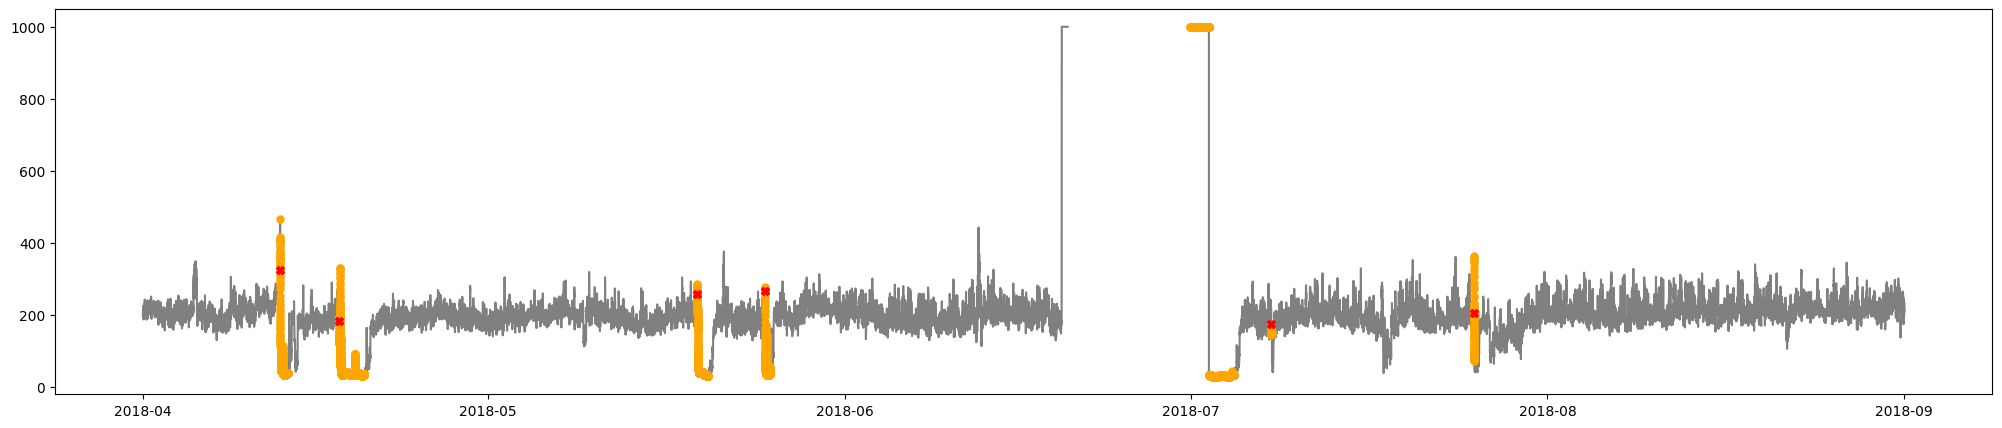

In [5]:
sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])
sensor_data.set_index('timestamp', inplace=True)


broken = sensor_data[sensor_data["machine_status"] == 'BROKEN']
recovery = sensor_data[sensor_data["machine_status"] == 'RECOVERING']
normal = sensor_data[sensor_data["machine_status"] == 'NORMAL']


def sensor_plot(sensor):
    fig, ax = plt.subplots(figsize=(25,5))
    ax.plot(sensor_data[sensor], color='grey')
    ax.plot(recovery[sensor], linestyle='none', color='orange', marker='o', markersize=5)
    ax.plot(broken[sensor], linestyle='none', marker='X', color='red')
    plt.show()

sensor_plot('sensor_51')


In [6]:
#filling NA and scaling the data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X = sensor_data.iloc[:,:-1]
X = X.fillna(X.mean())
X = scaler.fit_transform(X)


In [7]:
from sklearn.ensemble import IsolationForest

outliers_fraction = 1 - (len(normal)/(len(sensor_data))) # where the machine is either broken or recovering. 
isfo = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
ypred = isfo.fit_predict(X)

from joblib import dump

dump(isfo, "Isfo_classifier.joblib" )




['Isfo_classifier.joblib']

In [8]:
sensor_data["IsFo"] = ypred

anomaly = sensor_data[sensor_data['IsFo'] == -1]

def sensor_plot_isfo(sensor):
    fig, ax = plt.subplots(figsize=(25,5))
    ax.plot(sensor_data[sensor], color='grey')
    ax.plot(recovery[sensor], linestyle='none', color='orange', marker='o', markersize=5)
    ax.plot(broken[sensor], linestyle='none', marker='X', color='red', markersize=25)
    ax.plot(anomaly[sensor], linestyle='none', marker = 'X', color = 'blue')
    ax.set_title(sensor)
    plt.show()

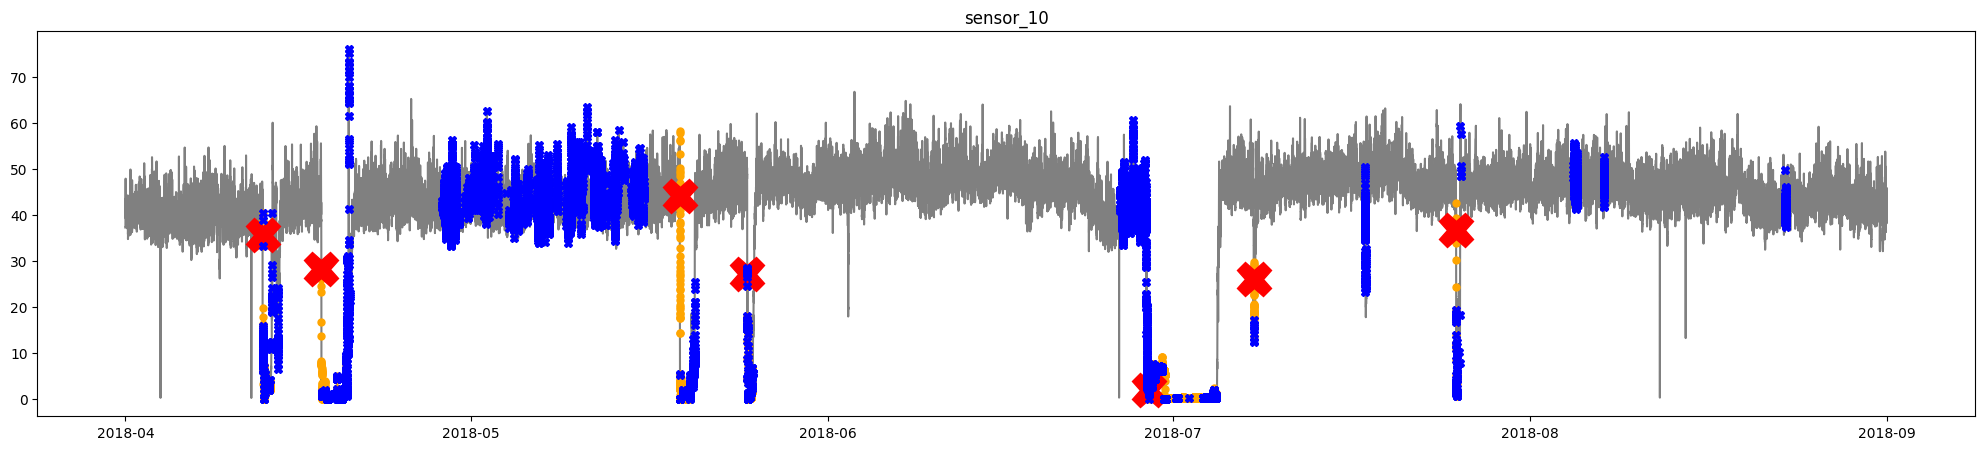

In [9]:
sensor_plot_isfo('sensor_10')